# Crear _wrapper_

Creamos un _wrapper_ que modifica las salidas de un modelo **ya entrenado** para que sea compatible con el formato `numpy`:

In [1]:
from sklearn.base import BaseEstimator, RegressorMixin

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Asume que el modelo ya está entrenado, por lo que no hacemos nada en fit
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Cargar modelo

Cargamos el modelo ya entrenado y le aplicamos el _wrapper_:

In [2]:
import sys
sys.path.insert(0,'./')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras import backend as K
Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004
Pres_mean = 548.729493
Pres_std = 30275.282659

model_tf = load_model('./Ptotal_Cp3D.h5')
model = KerasRegressorWrapper(model_tf)

2024-11-26 12:32:50.551651: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 12:32:50.716836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 12:32:51.362599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-11-26 12:32:52.376279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Cargar datos

Cargamos los datos de **calibración** y *_test_*:

In [3]:
import pandas as pd

features_dataset = pd.read_csv('./Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('./Dataset_test_P_UQ.csv')


# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')

# If your datasets are in Pandas format, you can set the sample size
sample_size = 1000  # Adjust as needed
# Take a random sample
features_sample = features_dataset.sample(n=sample_size, random_state=42)
P_sample = P_dataset.loc[features_sample.index]  # Use the same indices for P_dataset

print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

print(P_sample.shape)
print(features_sample.shape)

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
(1000, 1)
(1000, 11)


In [25]:
from sklearn.model_selection import train_test_split
#from sklearn.datasets import fetch_california_housing
#from sklearn.preprocessing import StandardScaler

features_sample = features_sample.to_numpy()
P_sample = P_sample.to_numpy()
#X_cal, X_test, y_cal, y_test = train_test_split(features_dataset, P_dataset, test_size=0.5, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(features_sample, P_sample, test_size=0.5, random_state=42)
print(X_cal.shape)
print(y_cal.shape)
print(X_test.shape)
print(y_test.shape)


(500, 11)
(500, 1)
(500, 11)
(500, 1)


# Cálculo de incertidumbre

Utilizamos `MapieRegressor`para calcular los intervalos de las predicciones:

In [26]:
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
import numpy as np

mapie_regressor = MapieRegressor(estimator=model, method="plus")

mapie_regressor.fit(X_cal, y_cal)
y_preds, y_intervals = mapie_regressor.predict(X_test, alpha=0.1)
coverage = regression_coverage_score(y_test, y_intervals[:, 0, 0], y_intervals[:, 1, 0])

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16/16 [==============================] - 0s 577us/step


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


Vemos algunos ejemplos:

In [27]:
y_intervals.shape

(500, 2, 1)

In [28]:
for i in range(500):
    #print(f"Predicción: {y_preds[i]:.2f} | Intervalo: {y_intervals[i].flatten()}")
    print("Anchura intervalo: ",y_intervals[i,1,0]-y_intervals[i,0,0])


Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  80944.0
Anchura intervalo:  

In [ ]:
print(X_test.shape)
print(y_test.shape)

(500, 11)
(500, 1)
[[-0.82421985 -0.15203623 -0.9690658  ... -0.9690658  -0.69500055
  -1.25139079]
 [-1.21258164 -0.02156969 -1.24166052 ... -1.24166052 -0.29835145
   0.81590596]
 [ 1.14280822 -0.15203623  1.32663987 ...  1.32663987  0.85977868
  -0.43470098]
 ...
 [-0.01219023 -0.15370888  0.3709171  ...  0.3709171  -0.55712752
  -0.95794041]
 [-0.14332533 -0.15370888  0.11145963 ...  0.11145963  0.33162011
  -1.16045879]
 [ 0.45182663 -0.15370888  0.96208603 ...  0.96208603  0.29980357
  -1.08222321]]
[[1.0865000e+05]
 [2.4790001e+04]
 [1.0137900e+06]
 [2.3078000e+05]
 [1.1227500e+06]
 [1.3508500e+06]
 [3.3457001e+05]
 [3.0234000e+05]
 [5.6522998e+05]
 [3.8282001e+05]
 [2.5353999e+05]
 [6.1646997e+05]
 [1.6117999e+05]
 [5.4860001e+04]
 [1.0118800e+06]
 [1.7423000e+05]
 [1.5867999e+05]
 [1.1025500e+06]
 [2.4002000e+05]
 [3.2967999e+05]
 [3.9590000e+04]
 [6.4134998e+05]
 [8.8335999e+05]
 [9.0859998e+05]
 [3.4979001e+05]
 [3.6462000e+05]
 [1.0161400e+06]
 [8.5647998e+05]
 [1.8706300e+

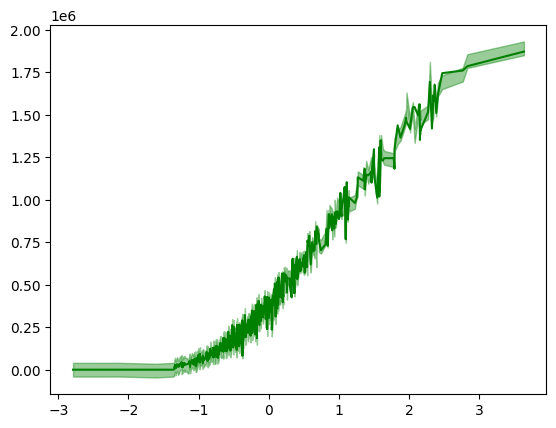

In [33]:
from matplotlib import pyplot as plt

order = np.argsort(X_test[:,0])
plt.plot(X_test[order,0],y_test[order,0],label='Predictions',color='green')
plt.fill_between(X_test[order,0],y_intervals[:,0,0][order],y_intervals[:,1,0][order],alpha=0.4,label='prediction intervals',color='green')